In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import Angle
from astropy.stats import sigma_clip
from astropy.io import fits
from astropy.nddata import Cutout2D
from astropy.wcs import WCS
import matplotlib.cm as cm
import scipy.misc
get_ipython().magic('matplotlib inline')

In [21]:
#### load data to pd.DateFrame

# clipped Bw/NB.fits
names1 = ['NUMBER', 'X_IMAGE', 'Y_IMAGE', 'ALPHA_J2000', 'DELTA_J2000', 'FLUX_APER', 'FLUXERR_APER', 'FLAGS', 'NITER_MODEL']
Bw_rawdata = pd.DataFrame(np.genfromtxt('Bw_cut.cat', delimiter = None, names = names1))
NB_rawdata = pd.DataFrame(np.genfromtxt('NB_cut.cat', delimiter = None, names = names1))

names2 = ['_RAJ2000', '_DEJ2000', 'RA_ICRS', 'DE_ICRS', 'mode', 'q_mode', 'class','SDSS12', 'm_SDSS12', 'ObsDate', 'Q', 'umag',\
          'e_umag', 'gmag', 'e_gmag', 'rmag', 'e_rmag', 'imag', 'e_imag', 'zmag', 'e_zmag', 'zsp', 'zph', 'e_zph', '<zph>']
SDSS_rawdata = pd.DataFrame(np.genfromtxt('SDSS', delimiter = '\t', skip_header = 10,names = names2))

# color transfer form u&r to b band
SDSS_rawdata['bmag'] = SDSS_rawdata.umag - 0.8116 * (SDSS_rawdata.umag - SDSS_rawdata.gmag) + 0.1313
# SDSS_rawdata['bmag'] = SDSS_rawdata.gmag + 0.3130 * (SDSS_rawdata.gmag - SDSS_rawdata.rmag) + 0.2271

In [22]:
#### data screening

# pick points whose flux > 0
Bw_data = Bw_rawdata[Bw_rawdata.FLUX_APER > 0].reset_index()
NB_data = NB_rawdata[NB_rawdata.FLUX_APER > 0].reset_index()
# pick points whose class are star(class = 6)
SDSS_data = SDSS_rawdata[SDSS_rawdata['class'] == 6].reset_index()# & (SDSS_rawdata.bmag > 17.5) & (SDSS_rawdata.bmag < 20.5)].reset_index()

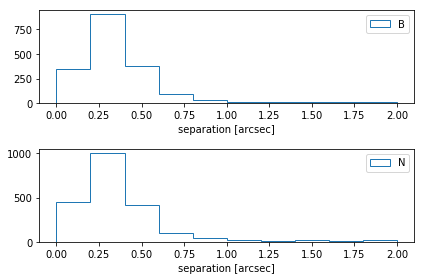

In [23]:
#### match source point between Bw/NB and SDSS

coo_Bw = SkyCoord(list(Bw_data.ALPHA_J2000) * u.degree, list(Bw_data.DELTA_J2000) * u.degree)
coo_NB = SkyCoord(list(NB_data.ALPHA_J2000) * u.degree, list(NB_data.DELTA_J2000) * u.degree)
coo_SDSS = SkyCoord(list(SDSS_data._RAJ2000) * u.degree, list(SDSS_data._DEJ2000) * u.degree)
idx_Bw, d2d_Bw, d3d_Bw = coo_SDSS.match_to_catalog_sky(coo_Bw)
idx_NB, d2d_NB, d3d_NB = coo_SDSS.match_to_catalog_sky(coo_NB)

# separation
plt.subplot(211)
plt.hist(d2d_Bw.arcsec, histtype='step', range=(0,2))
plt.xlabel('separation [arcsec]')
plt.legend('Bw')
plt.tight_layout()
plt.subplot(212)
plt.hist(d2d_NB.arcsec, histtype='step', range=(0,2))
plt.xlabel('separation [arcsec]')
plt.legend('NB')
plt.tight_layout()
plt.show()

In [24]:
# index - SDSS, idx_Bw - Bw
index_Bw = np.where((d2d_Bw < Angle('0d00m0.5s')))
index_NB = np.where((d2d_NB < Angle('0d00m0.5s')))
# select common points in Bw and NB
index = [index for index in index_Bw[0] if index in index_NB[0]]
idx_Bw = idx_Bw[index]
idx_NB = idx_NB[index]

D:\software\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
D:\software\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


standard deviation of zero points is: 2.042737787614197
Zero point for Bw band is:  23.33458902594903
standard deviation of zero points is: 2.2162205743157037
Zero point for NB band is:  21.202516595936416


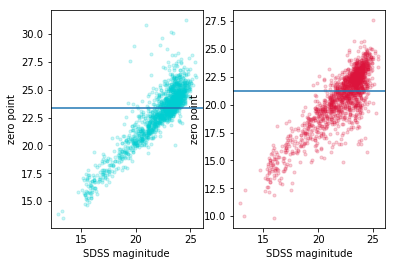

In [25]:
#### calibrate

Bw_data['mag'] = -2.5 * np.log10(Bw_data.FLUX_APER)
NB_data['mag'] = -2.5 * np.log10(NB_data.FLUX_APER)
# Bw_mag = [Bw_data['mag'][i] for i in idx_Bw]
# NB_mag = [NB_data['mag'][i] for i in idx_NB]
SDSS_mag = [SDSS_data.bmag[i] for i in index]
subt_SB = [SDSS_data['bmag'][i] - Bw_data['mag'][i] for i in index]
subt_SN = [SDSS_data['bmag'][i] - NB_data['mag'][i] for i in index]

zp_Bw = sigma_clip(subt_SB, sigma = 3, iters = 5)
zeropoint_Bw = np.median(zp_Bw)
zp_NB = sigma_clip(subt_SN, sigma = 3, iters = 5)
zeropoint_NB = np.median(zp_NB)

plt.figure()
plt.subplot(121)
plt.scatter(SDSS_mag, subt_SB, s = np.pi * 1.75**2, c = '#00CED1', alpha=0.2)
plt.axhline(np.median(zp_Bw))
plt.xlabel('SDSS maginitude'); plt.ylabel('zero point')
print('standard deviation of zero points is:', np.std(zp_Bw))
print("Zero point for Bw band is: ", zeropoint_Bw)
plt.subplot(122)
plt.scatter(SDSS_mag, subt_SN, s = np.pi * 1.75**2, c = '#DC143C', alpha=0.2)
plt.axhline(np.median(zp_NB))
plt.xlabel('SDSS maginitude'); plt.ylabel('zero point')
print('standard deviation of zero points is:', np.std(zp_NB))
print("Zero point for NB band is: ", zeropoint_NB)
plt.show()

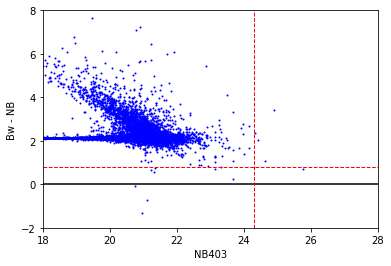

In [26]:
#### Bw - NB

coo_Bw = SkyCoord(list(Bw_data.ALPHA_J2000) * u.degree, list(Bw_data.DELTA_J2000) * u.degree)
coo_NB = SkyCoord(list(NB_data.ALPHA_J2000) * u.degree, list(NB_data.DELTA_J2000) * u.degree)
idx, d2d, d3d = coo_Bw.match_to_catalog_sky(coo_NB)
NB_data = NB_data.loc[idx].reset_index(drop = 'true')
plt.scatter(NB_data.mag + zeropoint_NB, Bw_data.mag - NB_data.mag + zeropoint_Bw - zeropoint_NB, \
            color = 'b', s=1)
plt.axhline(0, color='k', linestyle='solid')
plt.axhline(0.8, color='r', linestyle='--', linewidth = 1)
plt.axvline(20, color='r', linestyle='--', linewidth = 1)
plt.axis([18, 28, -2, 8])
plt.xlabel('NB403')
plt.ylabel('Bw - NB')
plt.show()